# IMPORT LIBRARIES

In [93]:
import torch
from torchvision import datasets
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy


# LOAD TRAIN & TEST DATA

In [3]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

# DATA LOADERS

In [4]:
loaders = {
    'train' : DataLoader(train_data, 
                        batch_size=100, 
                        shuffle=True, 
                        num_workers=1),
    'test'  : DataLoader(test_data, 
                        batch_size=100, 
                        shuffle=True, 
                        num_workers=1), }

# THE CNN

In [5]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x
    

# LOSS FUNCTION & ACTIVATION FUNCTION

In [6]:
from torch import optim
cnn = CNN()
optimizer = optim.Adam(cnn.parameters(), lr = 0.01) 
loss_func = nn.CrossEntropyLoss()


# TRAIN THE NETWORK

In [7]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    cnn.train()
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            optimizer.zero_grad()           
            loss.backward()
            optimizer.step()            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.0551
Epoch [1/10], Step [200/600], Loss: 0.0413
Epoch [1/10], Step [300/600], Loss: 0.1679
Epoch [1/10], Step [400/600], Loss: 0.1069
Epoch [1/10], Step [500/600], Loss: 0.0339
Epoch [1/10], Step [600/600], Loss: 0.0274
Epoch [2/10], Step [100/600], Loss: 0.0804
Epoch [2/10], Step [200/600], Loss: 0.0700
Epoch [2/10], Step [300/600], Loss: 0.0235
Epoch [2/10], Step [400/600], Loss: 0.0840
Epoch [2/10], Step [500/600], Loss: 0.0223
Epoch [2/10], Step [600/600], Loss: 0.0018
Epoch [3/10], Step [100/600], Loss: 0.0079
Epoch [3/10], Step [200/600], Loss: 0.0992
Epoch [3/10], Step [300/600], Loss: 0.0997
Epoch [3/10], Step [400/600], Loss: 0.0147
Epoch [3/10], Step [500/600], Loss: 0.0174
Epoch [3/10], Step [600/600], Loss: 0.0763
Epoch [4/10], Step [100/600], Loss: 0.0590
Epoch [4/10], Step [200/600], Loss: 0.0970
Epoch [4/10], Step [300/600], Loss: 0.1100
Epoch [4/10], Step [400/600], Loss: 0.0865
Epoch [4/10], Step [500/600], Loss: 0.0067
Epoch [4/10

# LET'S TEST

In [8]:
with torch.no_grad():
    correct = 0
    total = 0
    accuracy = 0
    for data in loaders['test']:
        images,labels = data
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy += (pred_y == labels).sum().item() / float(labels.size(0))
    print(accuracy/len(loaders['test']))

0.09239999999999998


# PREDICTIONS

In [9]:
sample = next(iter(loaders['test']))
imgs, lbls = sample
actual_number = lbls[:10].numpy()
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [8 8 8 8 8 8 8 8 8 8]
Actual number: [9 1 8 0 0 0 3 5 1 4]


In [15]:
torch.save(cnn,"models/MNIST_cnn.pt")
model = torch.load('models/MNIST_cnn.pt')
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


# ONNX

In [16]:
torch.onnx.export(model,
                 torch.randn(1, 1, 28, 28),
                 "models/mnist_cnn.onnx",
                 verbose=False,
                 input_names=[ "actual_input" ],
                 output_names=[ "outputs" ],
                 export_params=True,
                 )

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



# INFERENCING

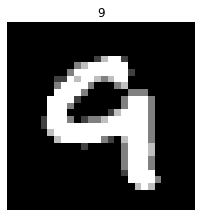

PREDICTED : 9


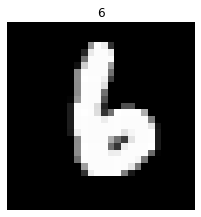

PREDICTED : 6


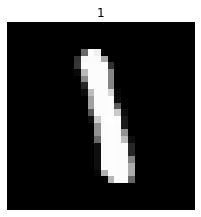

PREDICTED : 1


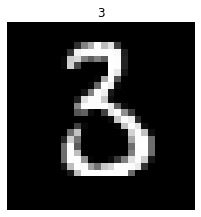

PREDICTED : 3


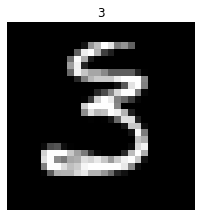

PREDICTED : 3


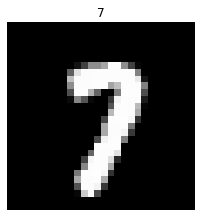

PREDICTED : 7


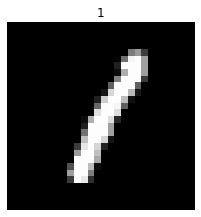

PREDICTED : 1


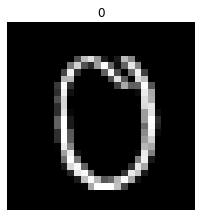

PREDICTED : 0


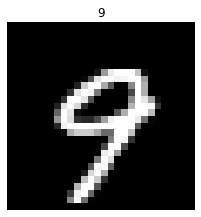

PREDICTED : 9


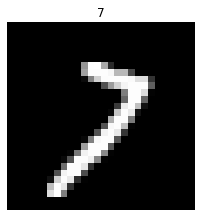

PREDICTED : 7


In [107]:
import onnxruntime
import numpy as np
import matplotlib.pyplot as plt



def infer(img,label,x):
    figure = plt.figure(figsize=(20, 20))
    cols, rows = 5, 5
    figure.add_subplot(rows, cols, x+1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.show()
    result = session.run([output_name], {input_name: img.numpy()})
    prediction=int(np.argmax(np.array(result).squeeze()))
    print("PREDICTED : "+str(prediction))
    
model_dir ="./models"
model=model_dir+"/mnist_cnn.onnx"
session = onnxruntime.InferenceSession(model)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
sample = next(iter(loaders['test']))
imgs, lbls = sample
for x in range(10):
    infer(imgs[x:x+1],str(int(lbls[x])),x)
